# PFA: Partie de la reconnaissance des tableaux de signalisation de vitesse

Dans cette partie, nous allons construire un modèle avec lequel nous pouvons faire la détection des panneaux de signalisation, à partir d'un flux vidéo capturé par la caméra de la voiture. <br><br>
L'apprentissage de ce modèle est basé sur le réseau de neurones de convolution (CNN) qui permet d'extraire les traits et les caractéristiques d'une image sur lesquelles il se base pour faire la prédiction lors de la partie de la reconnaissance réelle. <br>
Pour implémenter le CNN, on va utiliser l'API du TensorFlow <b>Keras</b>, qui facilite la construction des différentes couches du réseau de neurones. <br><br>
Pour les opérations sur les images, il n'y a pas mieux que la bibliothèque <b>OpenCV</b> qui propose de nombreuses API pour la manipulation des flux vidéo et image en temps réel, et ainsi pour les différentes transformations qui seront appliquées sur ces derniers. <br><br>
L'entraînement du model va se faire avec la méthode du 'train, test, validation split' trouver dans la bibliothèque <b>Scikit Learn</b>. Avec elle, la dataset est divisé en 3 parties: <br>
* La grande partie 'train': elle contient les images que le réseau de neurones va utiliser pour extraire les caractéristiques et régler les poids et les biais de ses liaisons. <br>
* La partie 'validation': elle contient les images avec lesquelles, et au cours d'entraînement, le modèle va tester son apprentissage et va régler ses paramètres pour avoir une meilleur accuracy après chaque epoch. <br>
* La partie 'test': cette partie contient les images que le modèle va tester, après la fin de son apprentissage, son accuracy et son aptitude à prédire de nouvelles images jamais vues par lui. <br><br>

Enfin, on utilise les bibliothèques <b>Numpy</b> et <b>Pandas</b> pour la manipulation des arrays et dataframes, et <b>MatPlotLib</b> et <b>Seaborn</b> pour l'affichage des graphes et des courbes. <br>

## 1. Importation des bibliothèques utiles

La première partie va juste importer les différentes bibliothèques de Python utilisées dans ce code.

In [1]:
# ---------------------------- KERAS ---------------------------- #
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# ------------------------ Scikit Learn ------------------------ #
from sklearn.model_selection import train_test_split

# --------------------------- OpenCV --------------------------- #
import cv2

# ------------------- Numpy, Matplotlib, Pandas ---------------- #
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --------------- Other useful Python libraries ---------------- #
import random
import os

## 2. Exploration de la Dataset

La Dataset qu'on va utiliser est celle de l'institut allemand de la neuro-informatique (https://www.ini.rub.de/index.html) qui est composée de plus de 50,000 images colorées de 40 différentes classes/panneaux, de dimension 32x32. 

Cette Dataset est téléchargeable à partir de ce lien : https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html

Comme nous avons besoin juste des panneaux de limitations de vitesses, on peut supprimer tous les autres à partir du fichier téléchargé. (Le fichier <i>.csv</i> indique la correspondance entre les classes et les panneaux de signalisation. Ce fichier doit être changé de la même manière). <br>

Après la suppression, on peut analyser le contenu du fichier <i>.csv</i> à partir du code.

In [2]:
labels_file = "Dataset/labels.csv"         # .csv file path
data = pd.read_csv(labels_file)    # get data from .csv file
nb_classes = len(data.index)       # get number of rows (classes) in the file
print("Number of classes: ", nb_classes)
data

Number of classes:  8


,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,Speed limit (100km/h)
7,7,Speed limit (120km/h)


Maintenant on importe les images de la dataset dans les dossiers correspondants.

In [4]:
count = 0                  # used as class number in the loop
path = "dataset/images/"          # dataset folder path
images = []                # will hold all the images
classes = []               # will hold all their corresponding classes, organized   

# loop every subfolder inside the dataset top folder
for folder_name in range(0, nb_classes):
    
    folder_contents = os.listdir(path + str(count)) # get the contents (images) of the subfolder
    last_class_img_count = len(images)              # used to calculate the number of images in every class
    
    # loop every element (image) in the subfolder
    for element_name in folder_contents:
        
        img = cv2.imread(path + str(count) + "/" + element_name)  # read the image with OpenCV
        images.append(img)                                        # add the image to the images global list
        classes.append(count)                                     # add its class to the classes global list
    
    current_class_img_count = len(images) - last_class_img_count
    print(count, end=" ")
    print(current_class_img_count, end="\n")
    count += 1
    

print("Total", len(images))

images  = np.array(images)
classes = np.array(classes)

0 180
1 1980
2 2010
3 1260
4 1770
5 1650
6 1290
7 1260
Total 11400


On peut visualiser cette répartition en un graphe:

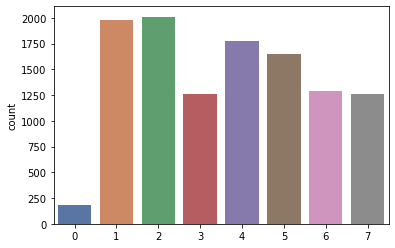

In [5]:
sns.countplot(x=classes, palette='deep');

On peut afficher les dimensions de ces tableaux de numpy:

In [6]:
print("Images:", images.shape)
print("Classes:", classes.shape)

Images: (11400, 32, 32, 3)
Classes: (11400,)


Et enfin, le code suivant permet d'afficher quelques images aléatoires de la Dataset:

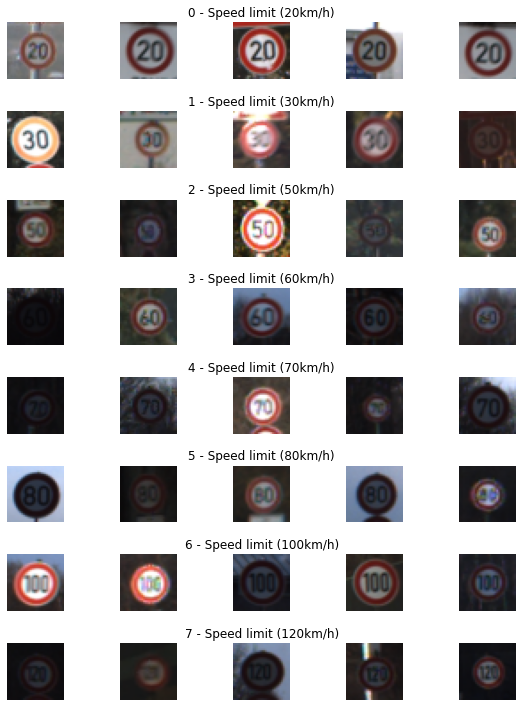

In [7]:
cols = 5                  # number of images per class to show 

# matplotlib plot function
fig, axs = plt.subplots(nrows=nb_classes, ncols=cols, figsize=(8,10))
fig.tight_layout()

# loop through the columns
for i in range(cols):
    
    # loop through the rows, with the index
    for j, row in data.iterrows():
        
        x_selected = images[classes == j]    # select all the images in the given j class
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :])    # show five of them randomly
        axs[j][i].axis("off")     # hide extra measures
        
        if i == 2 : axs[j][i].set_title(str(j) + " - " + row["Name"])   # print the name of the class once

## 3. Division de la Dataset : Train, Validation, Test

Dans cette partie, on va diviser la Dataset en 3 parties: partie de l'entraînement, une autre pour la validation, et une troisième pour le test. <br><br>
En premier lieu, on va divisé la Dataset en deux partie: 
* Train : 80%
* Test  : 20%

En suite, on va prendre 20% de la partie Train pour la partie Validation. <br>
La division aura lieu sur les images et les classes en même temps.

In [8]:
test_ratio = 0.2
validation_ratio = 0.2

# Test-Train split
x_train, x_test, y_train, y_test = train_test_split(images, classes, test_size=test_ratio)
# Validation-Train split
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_ratio)

print("Train", end=" ")
print(x_train.shape, y_train.shape)

print("Test", end=" ")
print(x_test.shape, y_test.shape)

print("Validation", end=" ")
print(x_validation.shape, y_validation.shape)

Train (7296, 32, 32, 3) (7296,)
Test (2280, 32, 32, 3) (2280,)
Validation (1824, 32, 32, 3) (1824,)


## 4. Pré-Traitement des données

Cette partie est critique dans la démarche de l'apprentissage par les réseaux de neurones. Elle permet de rendre tous les images en nuances de gris, standariser les valeurs de leurs pixels entre -1 et 1 au lieu de la plage 0 à 255, et equaliser l'histogramme de l'intensité de l'image. <br>

On procède avec les fonctions suivantes:

In [9]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

On applique le pré-traitement sur les 3 parties des données:

In [10]:
x_train = np.array(list(map(preprocess, x_train)))
x_validation = np.array(list(map(preprocess, x_validation)))
x_test = np.array(list(map(preprocess, x_test)))

En suite on transforme la forme des 3 tableaux de données en un une nouvelle forme 1-D compatible avec le réseau de neurones qu'on va utiliser par la suite. (Une epaisseur de 1)

In [11]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_validation = x_validation.reshape(x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

print("Train", end=" ")
print(x_train.shape, y_train.shape)

print("Test", end=" ")
print(x_test.shape, y_test.shape)

print("Validation", end=" ")
print(x_validation.shape, y_validation.shape)

Train (7296, 32, 32, 1) (7296,)
Test (2280, 32, 32, 1) (2280,)
Validation (1824, 32, 32, 1) (1824,)


On applique ensuite l'augmentation des données qui permet de remplacer les images avec des des versions aléatoirement rotationnées, redimensionnées, décalées, rognées...

In [12]:
# data generator that takes change parameters
dataGen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
# apply the changes 
dataGen.fit(x_train)

# suffle the results before saving them 
batches = dataGen.flow(x_train, y_train, batch_size=20)
x_batch, y_batch = next(batches)

On peut visionner ces changements par le code suivant:

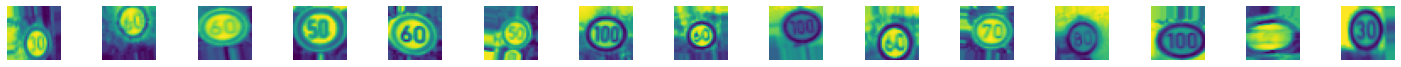

In [13]:
image_dim = (32,32,3)
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(x_batch[i].reshape(image_dim[0],image_dim[1]))
    axs[i].axis('off')

plt.show()

Ensuite on doit changer la classification des panneaux d'une classification à 8 états à une classification binaire catégorisée.

In [14]:
y_train = to_categorical(y_train, nb_classes)
y_validation = to_categorical(y_validation, nb_classes)
y_test = to_categorical(y_test, nb_classes)

## 5. Création du modèle CNN 

Dans cette partir nous allons construire le réseau de neurones qui va être utilisé pour extraire les caractéristiques des images pour construire un modèle de prédiction qu'on peut le sauvgarder et l'utiliser séparament.

In [15]:
def cnn_model():
    nb_filters = 60
    size_filter = (5,5)
    size_filter_2 = (3,3)
    size_pool = (2,2)
    nb_nodes = 500
    
    model = Sequential()
    # Input
    model.add((Conv2D(nb_filters, size_filter, input_shape=(image_dim[0], image_dim[1], 1), activation='relu')))
    model.add((Conv2D(nb_filters, size_filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_pool))
    model.add((Conv2D(nb_filters//2, size_filter_2, activation='relu')))
    model.add((Conv2D(nb_filters//2, size_filter_2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_pool))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(nb_nodes, activation='relu'))
    model.add(Dropout(0.5))
    
    #Output
    model.add(Dense(nb_classes, activation='softmax'))
    
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

On peut lancer maintenant le processus d'apprentissage avec ce CNN construit. 

In [16]:
batch_size = 50
steps_per_epoch = 145
epochs_val = 10

model = cnn_model()

history = model.fit(dataGen.flow(x_train, y_train, batch_size=batch_size), 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=epochs_val, 
                              validation_data=(x_validation, y_validation), 
                              shuffle=1)

Epoch 1/10
145/145 [==============================] - 50s 342ms/step - loss: 1.9895 - accuracy: 0.1753 - val_loss: 1.9672 - val_accuracy: 0.1853
Epoch 2/10
145/145 [==============================] - 59s 404ms/step - loss: 1.9670 - accuracy: 0.1931 - val_loss: 1.8719 - val_accuracy: 0.2473
Epoch 3/10
145/145 [==============================] - 65s 449ms/step - loss: 1.8520 - accuracy: 0.2690 - val_loss: 1.6361 - val_accuracy: 0.3898
Epoch 4/10
145/145 [==============================] - 57s 390ms/step - loss: 1.5869 - accuracy: 0.3820 - val_loss: 1.0445 - val_accuracy: 0.6809
Epoch 5/10
145/145 [==============================] - 52s 357ms/step - loss: 1.1741 - accuracy: 0.5667 - val_loss: 0.5518 - val_accuracy: 0.8525
Epoch 6/10
145/145 [==============================] - 56s 389ms/step - loss: 0.8478 - accuracy: 0.6920 - val_loss: 0.3758 - val_accuracy: 0.8942
Epoch 7/10
145/145 [==============================] - 57s 396ms/step - loss: 0.6222 - accuracy: 0.7818 - val_loss: 0.2461 - val_ac

## 6. Afficher le graphe de l'Accuracy et du Loss

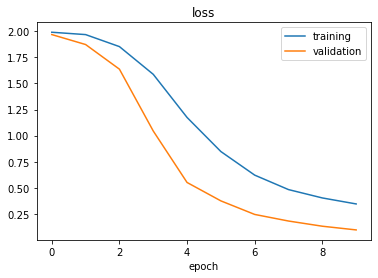

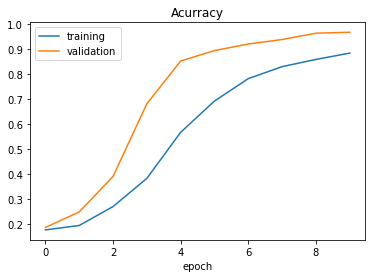

Test Score: 0.09512751549482346
Test Accuracy: 0.9719298481941223


In [17]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['test','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

## 7. Enregister le modèle entraîné

In [18]:
model.save("model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model\assets
